In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian

%matplotlib inline

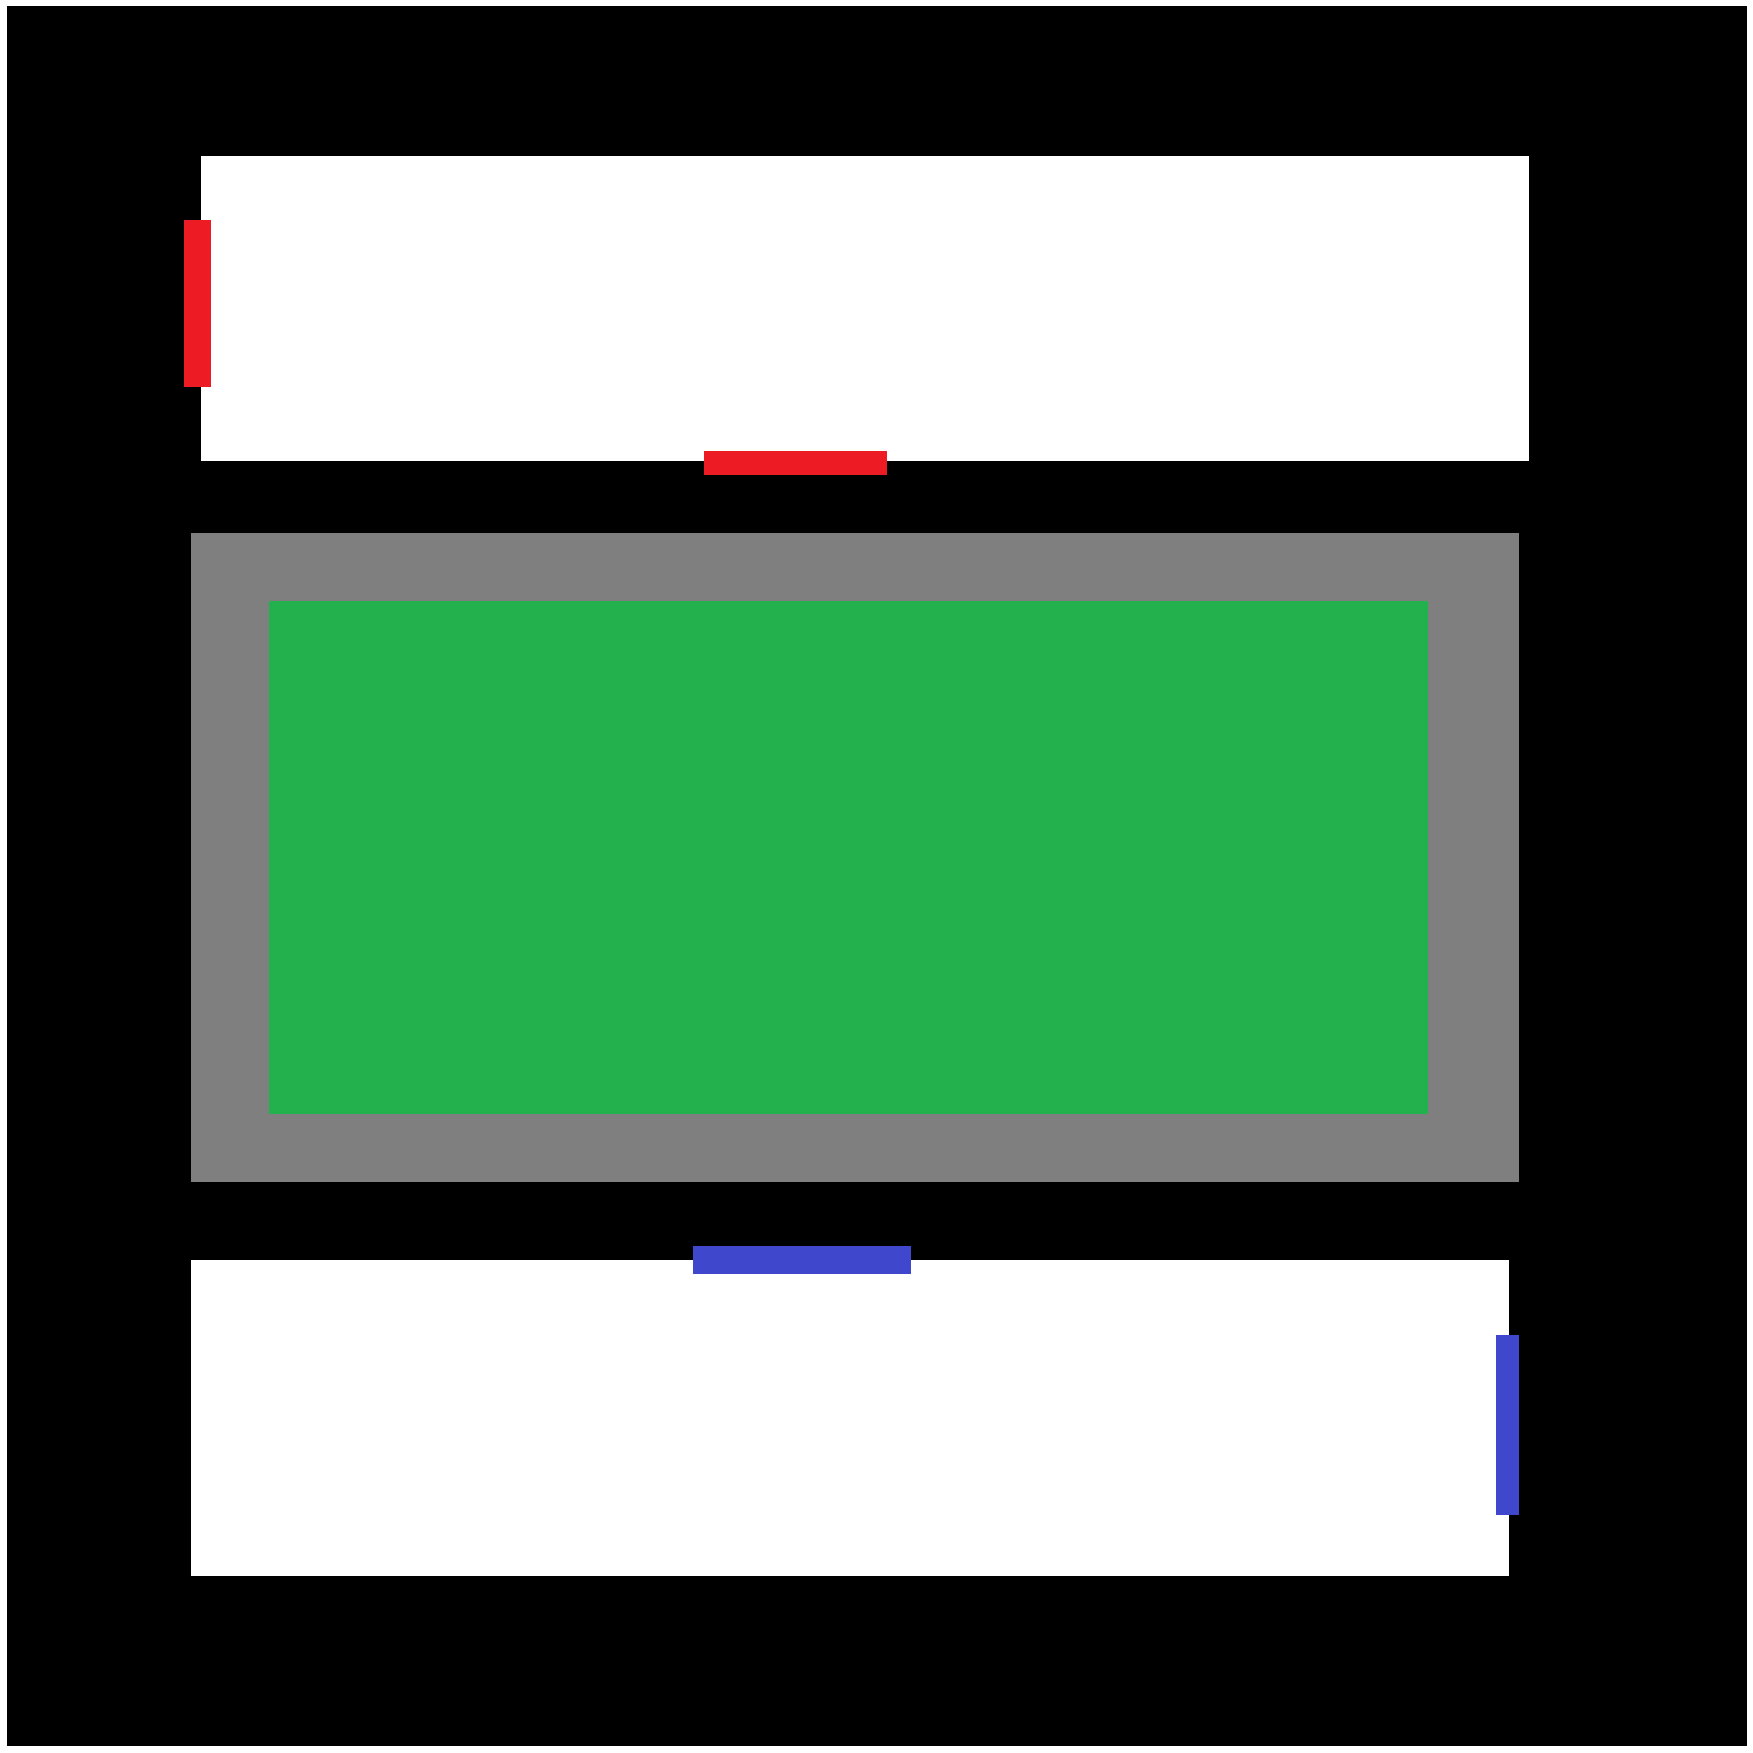

In [113]:
def display(image, cmap='gray'):
    '''
    Use matplotlib to display an image
    '''
    plt.figure(figsize=(32,32))
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()    

img = cv2.imread('basic_map.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

In [40]:
'''
Define the colors that we want to separate out. 
Each color needs to have a separate vector field so that weighting can be done.
For example, the aversion to walk on grass is much less than the aversion to walk into a wall.
Similarly, there is an attraction to walk on a path rather than on the road.
'''

path = np.array([127, 127, 127])
grass = np.array([34, 177, 76])
obstacle = np.array([255, 255, 255])
red = np.array([237, 28, 36])
blue = np.array([63, 72, 204])

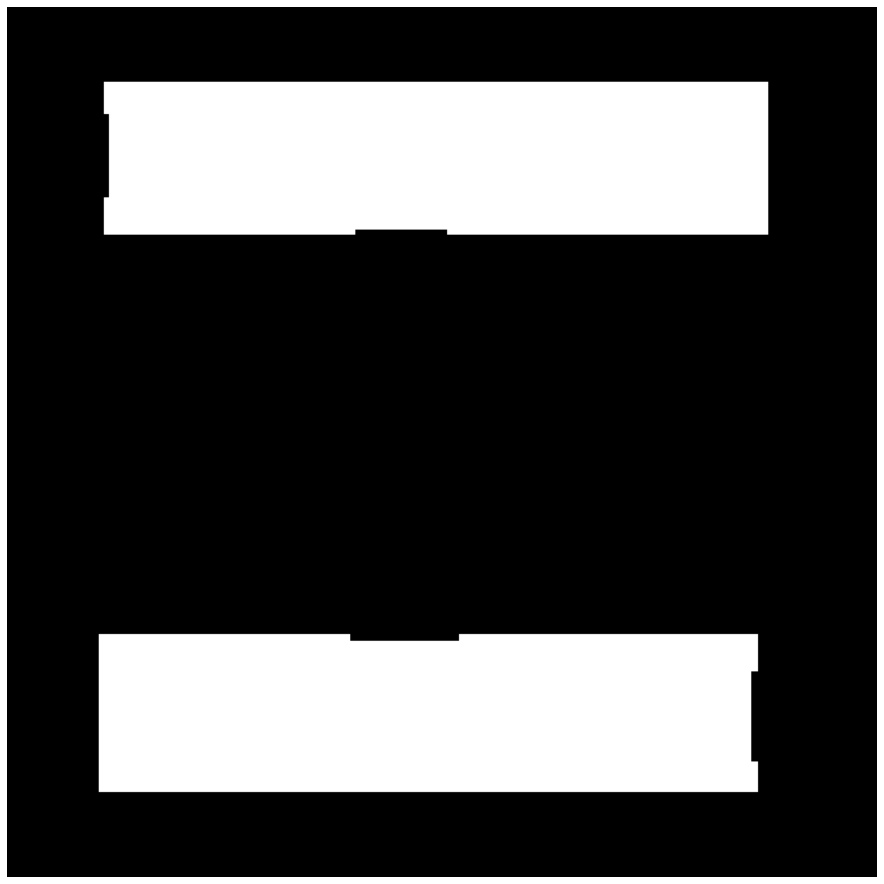

In [41]:

display(mask(obstacle, img))

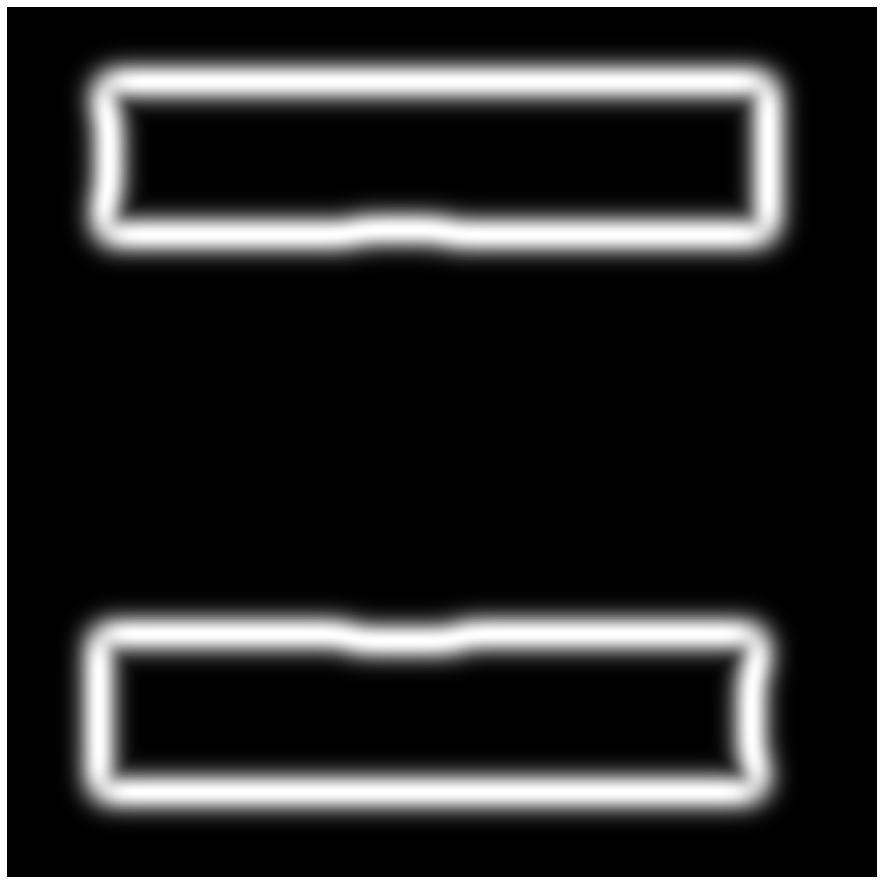

In [42]:
obs_mask = mask(obstacle, img).astype(bool)

# Use np.gradient to find the gradient of the brightness
# Apply a Gaussian blurring filter to smooth out the boundaries of the obstacles
# This generates a gradient field that increases as you get closer to the building
dy, dx = np.gradient(gaussian(mask(obstacle, img), sigma=8))

# I was trying to plot the gradient field using a quiver plot but I couldn't get it working well
center = 133
lim = 10
pixels = np.linspace(0, 512, 512, endpoint=False).astype(int)
x, y = np.meshgrid(pixels, pixels)



# Here is a display of the magnitude of the gradient field. 
# I removed the actual building using the mask since I wanted to show where the field is (not the building).
magnitude = np.sqrt(dx ** 2 + dy ** 2)
display(magnitude)


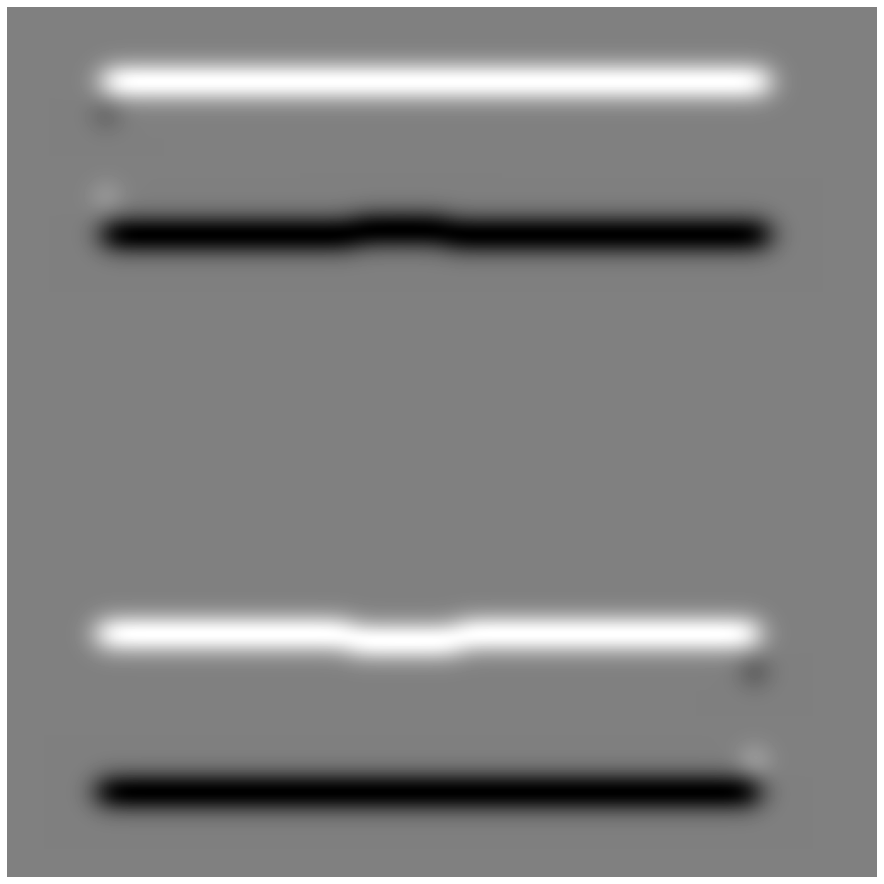

In [43]:
display(dy)

In [44]:
dx[133, 133], dy[133,133]

(0.0, -0.04967613256579581)

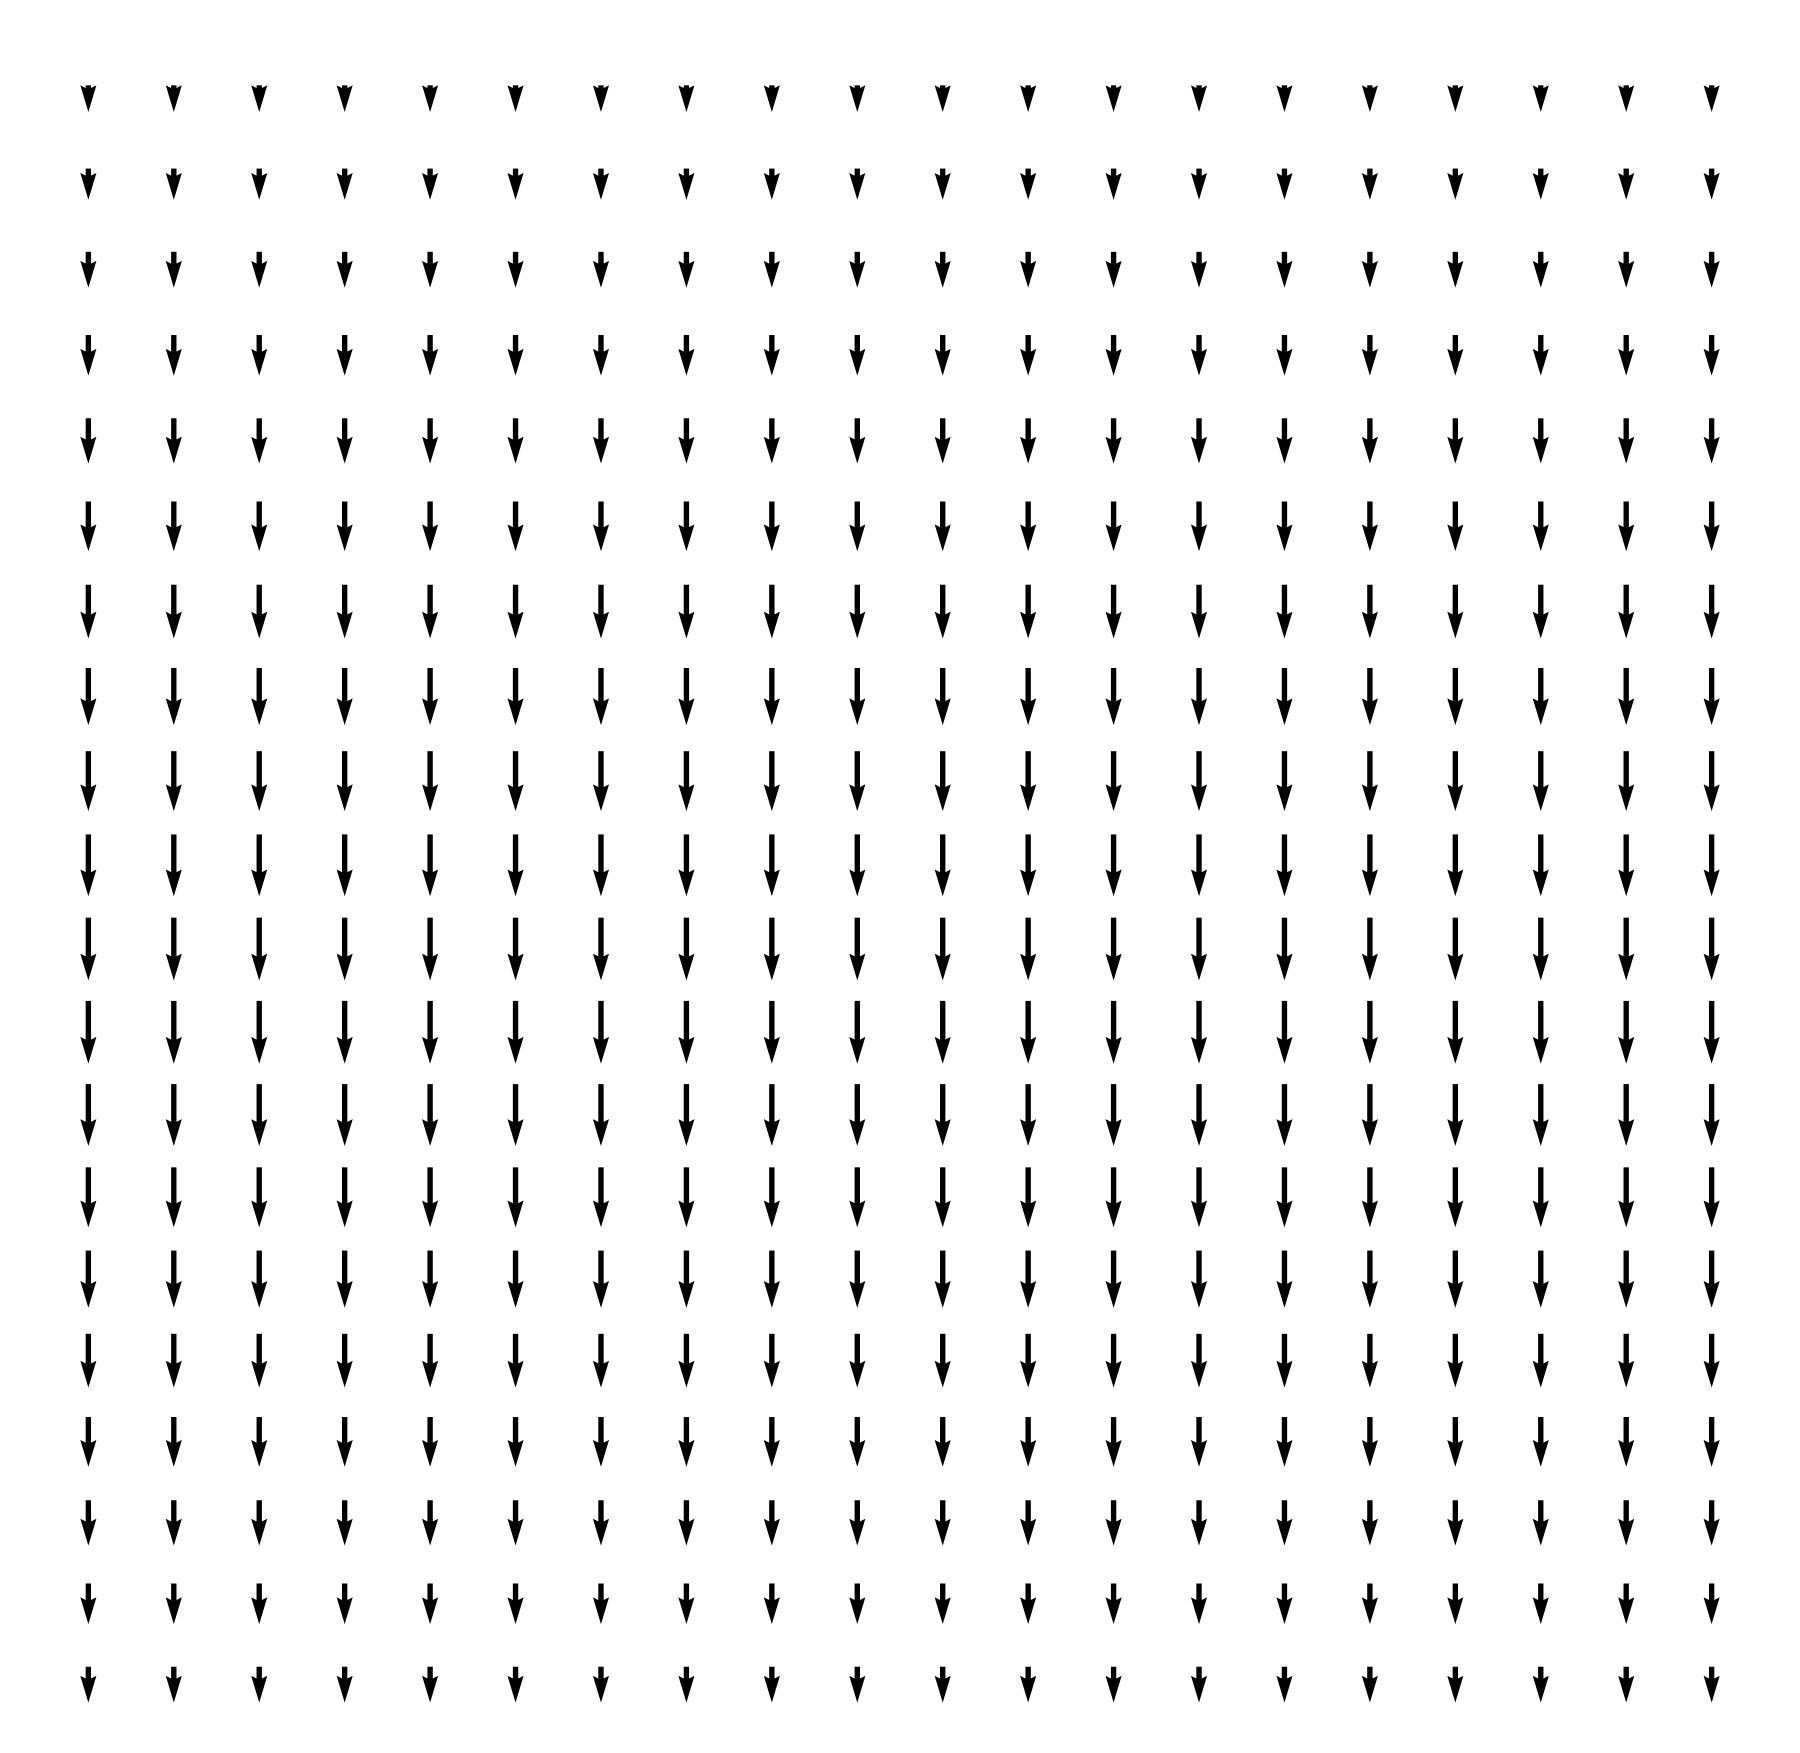

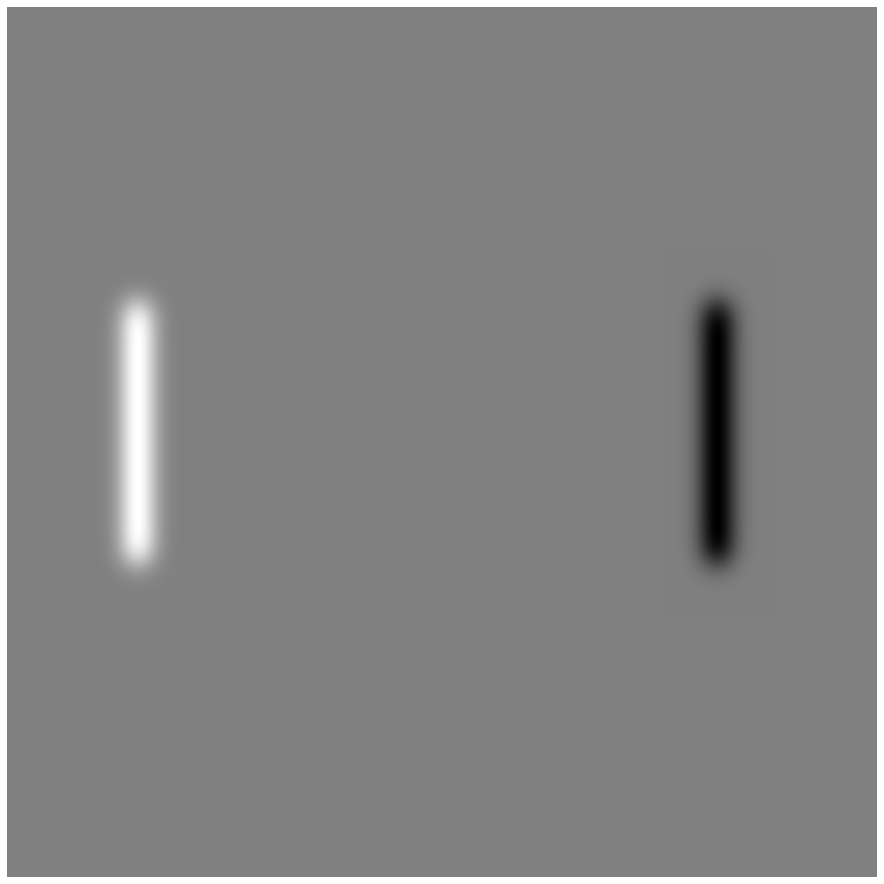

In [47]:
# Doing the same process, but for the grass. 

grass_mask = mask(grass, img).astype(bool)

dy, dx = np.gradient(gaussian(mask(grass, img), sigma=8))



magnitude = np.sqrt(dx ** 2 + dy ** 2)

display(np.where(grass_mask, dx, dx))


In [114]:
def crop(data, center, lim):
    
    return data[center[1]-lim:center[1]+lim, center[0]-lim:center[0]+lim]

def display_image(image, cmap='gray'):
    '''
    Use matplotlib to display an image
    '''
    plt.figure(figsize=(32,32))
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()    

def get_color_mask(color, img):
    '''
    Create a mask for where a color is located on the image.
    To do this we need to create 3 masks, one for each color channel, and AND them together.
    '''
    return ((img[:, :, 0] == color[0]) & (img[:, :, 1] == color[1]) & (img[:, :, 2] == color[2]))

def plot_vector_field(dy, dx, center, lim):
    '''
    Plot the vector field at a given center with bounds of [center-lim,center+lim] in both x,y directions
    '''

    pixels = np.linspace(0, 512, 512, endpoint=False).astype(int)
    x, y = np.meshgrid(pixels, pixels)

    plt.figure(figsize=(32,32))

    # Reverse y coordinates because image and axes y are reverses.
    plt.quiver(crop(x,center,lim), crop(y,center,lim)[::-1], crop(dx,center,lim), crop(dy,center,lim))
    plt.axis('off')
    plt.show()

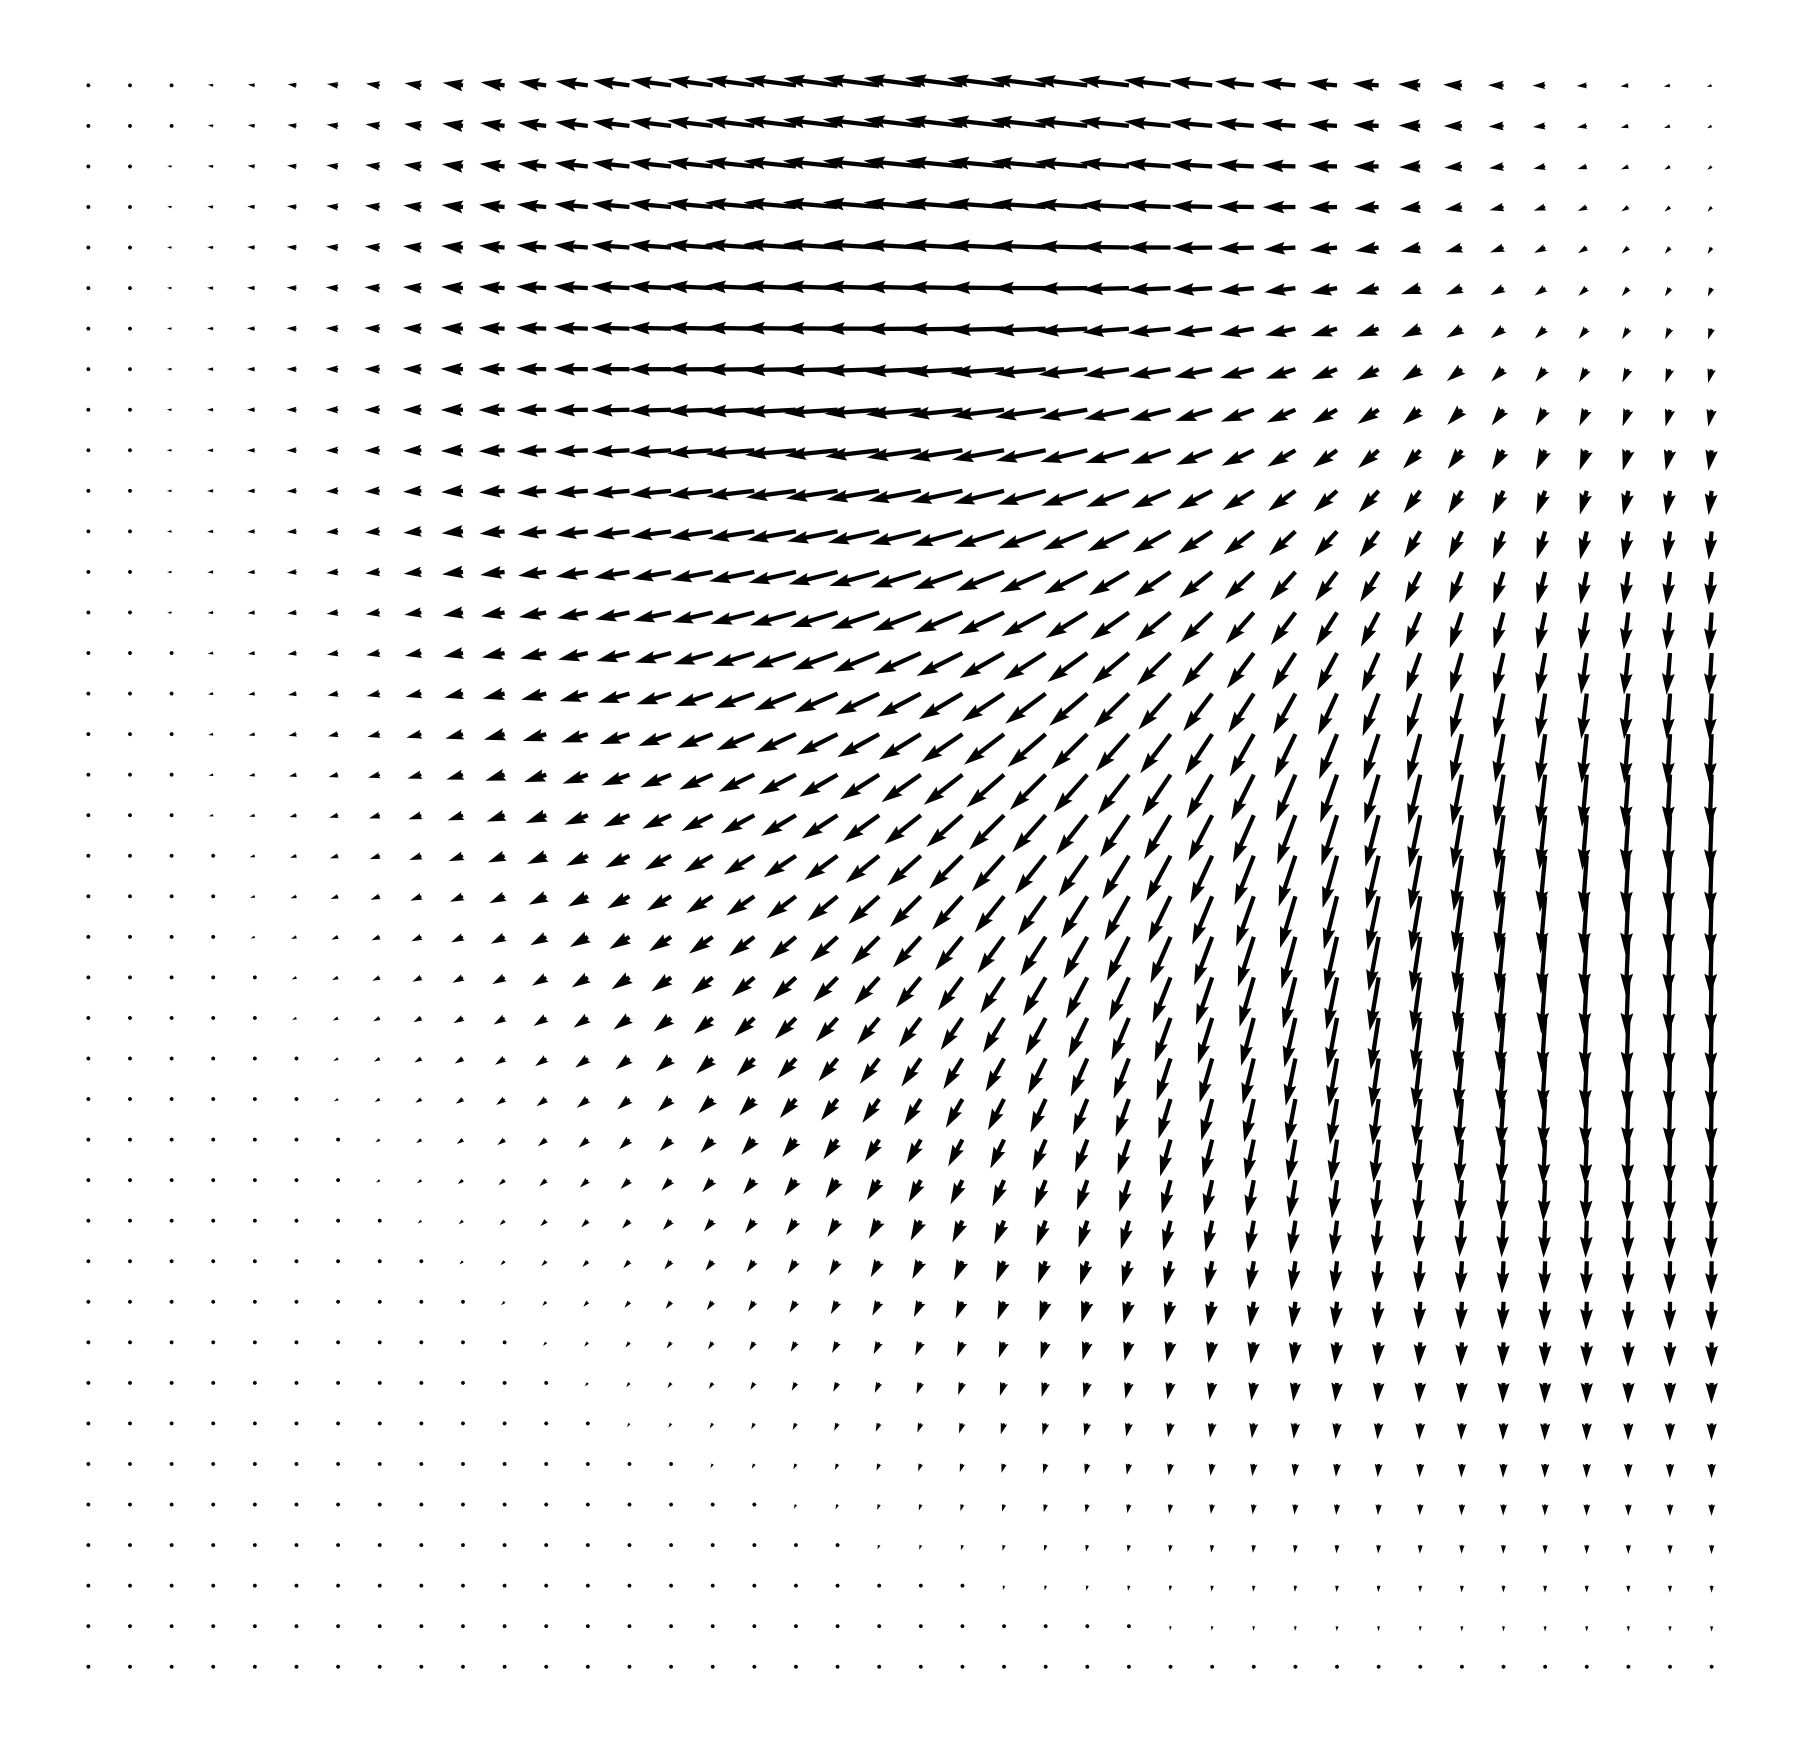

In [105]:
dy,dx,mask,mag = get_vector_field(img, obstacle, sigma=8, forceToEnter=1, forceToLeave=1)
center = (57,133)
lim = 20
# display_image(crop(mag, center, lim))
plot_vector_field(dy, dx, center, lim)

# display_image(crop(img, center, lim))

In [94]:
import numpy as np
from skimage.filters import gaussian

class MapColorElement:
    def __init__(self, name, color, blurSigma, forceToEnter, forceToLeave):
        self.name = name
        self.color = color
        self.blurSigma = blurSigma
        self.forceToEnter = forceToEnter
        self.forceToLeave = forceToLeave
    
    def get_vector_field(self, image):
        '''
        Calculate gradient over a slightly blurred image for a specific color
        This lets us calculate the vector field for a specific environment object (e.g. obstacle)
        '''
        color_mask = get_color_mask(self.color, image)
        dy, dx = np.gradient(gaussian(color_mask.astype(float), sigma=self.blurSigma))

        # Force to enter is already negative (we don't want to enter an obstacle) 
        # but we negate it again to make positive so that the gradient field points away stronger
        dy *= np.where(~color_mask, -self.forceToEnter, self.forceToLeave)
        dx *= -np.where(~color_mask, -self.forceToEnter, self.forceToLeave)

        return dy, dx, color_mask


MAP_ELEMENTS = [
    MapColorElement('path', path, 4, 1, -1),
    MapColorElement('grass', grass, 4, 1, 1),
    MapColorElement('obstacle', obstacle, 4, -2, 0),
    MapColorElement('red', red, 16, 1, 1),
    MapColorElement('blue', blue, 16, 1, 1)
]

In [95]:
def getTotalField(elements, image):
    vecField = np.zeros((512, 512, 2))
    for element in elements:
        dy, dx, mask = element.get_vector_field(image)
        vecField[:, :, 0] += dx
        vecField[:, :, 1] += dy
    return vecField

In [96]:
field = getTotalField(MAP_ELEMENTS, img)

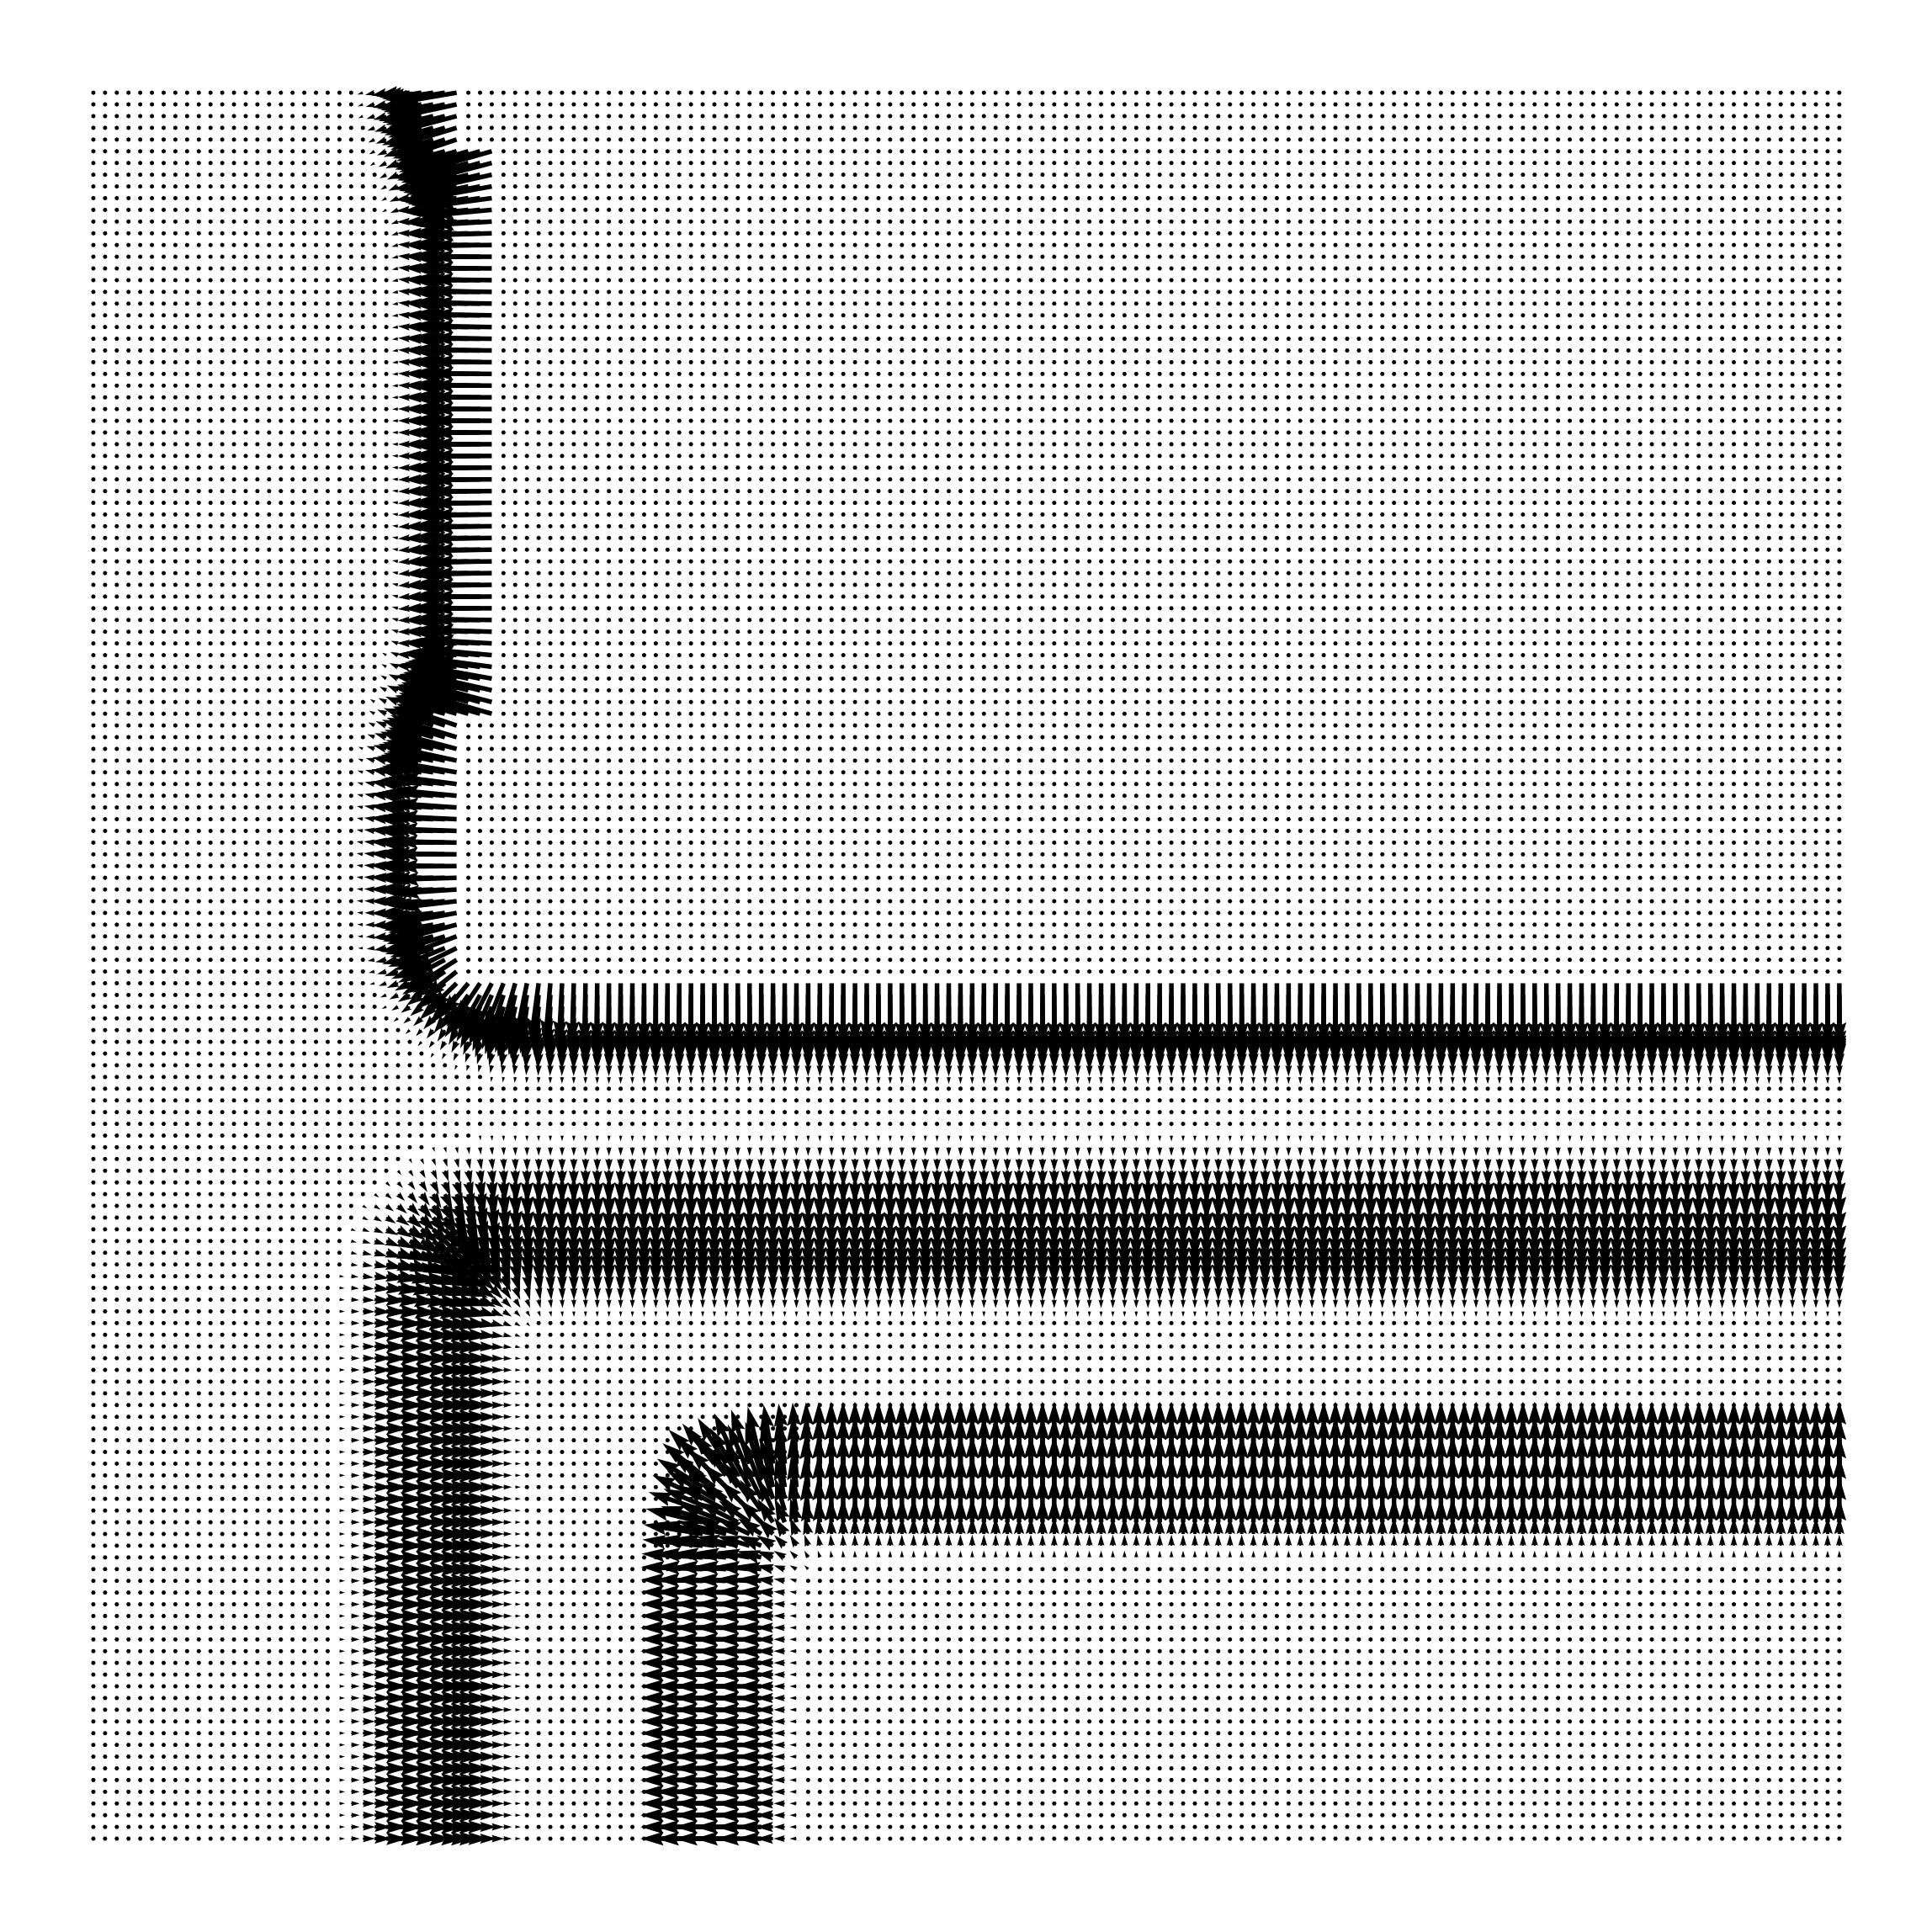

In [116]:
plt.figure(figsize=(32,32))
center = (100,133)
lim = 75
plt.quiver(crop(x,center,lim), crop(y,center,lim)[::-1], crop(field[:,:,0], center, lim), crop(field[:,:,1], center, lim))
plt.axis('off')
plt.show()

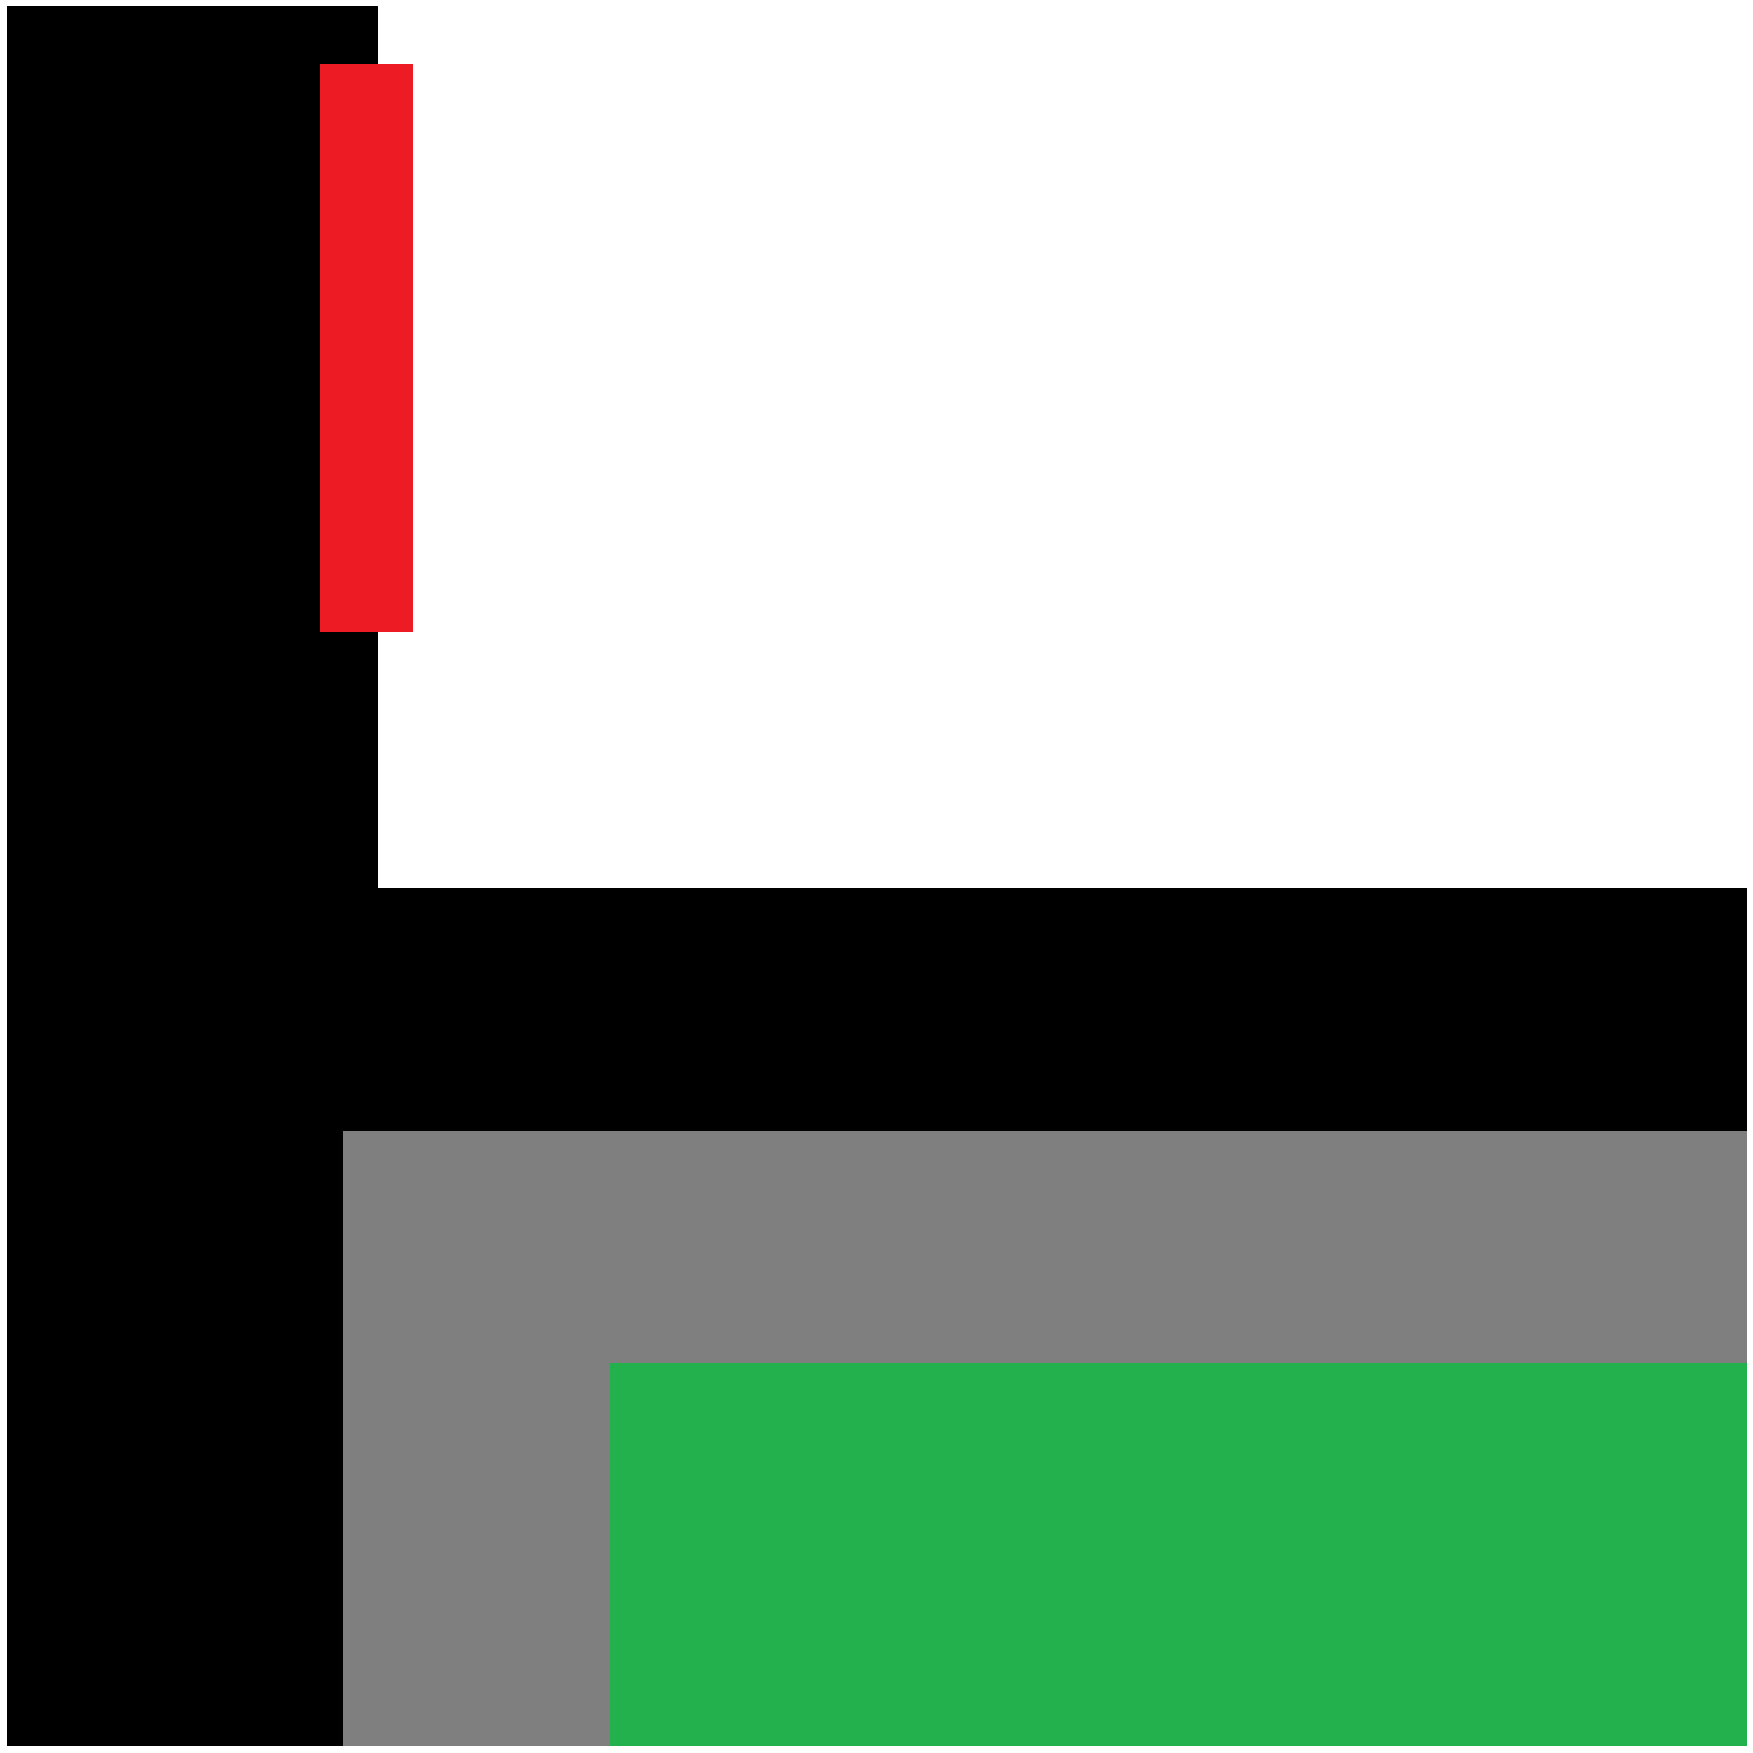

In [115]:
display_image(crop(img, center, lim))

In [ ]:
# Might have to normalize the vector field after computing


In [117]:
fieldStr = '\n'
for y in range(0,512):
    for x in range(0,512):
        fieldStr += f'[{field[y,x,0]:.2f},{field[y,x,1]:.2f}] '
    fieldStr += '\n'
fieldStr

'\n[0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0.00,-0.00] [-0

In [118]:
# write fieldStr to a file named "field.txt"
with open('field.txt', 'w') as f:
    f.write(fieldStr)